In [1]:
%%html
<script>
(function() {
  // Create the toggle button
  const rtlButton = document.createElement("button");
  rtlButton.textContent = "Toggle LTR";
  rtlButton.id = "top-rtl-toggle";
  rtlButton.style.marginLeft = "8px";
  rtlButton.style.padding = "4px 10px";
  rtlButton.style.fontSize = "14px";
  rtlButton.style.cursor = "pointer";

  // State
  var rtlActive = false;

  // Styling function
  var applyStyleToEditor = (editor) => {
    if (!editor) return;
    var direction = getComputedStyle(editor).getPropertyValue('direction')=='rtl' ? 'ltr' : 'rtl';
    var text_align = getComputedStyle(editor).getPropertyValue('text-align')=='right' ? 'left' : 'right';
    editor.style.setProperty('direction', direction, 'important');
    editor.style.setProperty('text-align', text_align, 'important');
  };

  // Toggle logic
  rtlButton.onclick = () => {
    rtlActive = !rtlActive;
    rtlButton.textContent = rtlActive ? "Toggle LTR" : "Toggle RTL";
    document.querySelectorAll('.jp-MarkdownCell .jp-InputArea-editor').forEach(applyStyleToEditor);
    document.querySelectorAll('.jp-RenderedHTMLCommon code, .jp-RenderedHTMLCommon code span').forEach(applyStyleToEditor);
    document.querySelectorAll('jp-RenderedHTMLCommon, .jp-RenderedHTMLCommon *').forEach(applyStyleToEditor);
  };

  // Watch for focus into editing Markdown cells
  // document.addEventListener('focusin', (event) => {
  //   const editor = event.target.closest('.jp-MarkdownCell .jp-InputArea-editor');
  //    if (editor) applyStyleToEditor(editor);
  // });

  // Insert into top toolbar if not already present
  var insertIntoToolbar = () => {
    const toolbar = document.querySelector('.jp-NotebookPanel-toolbar');
    if (toolbar && !document.getElementById("top-rtl-toggle")) {
      toolbar.appendChild(rtlButton);
    } else {
      // Try again in a moment if toolbar isn't ready yet
      setTimeout(insertIntoToolbar, 300);
    }
  };

  insertIntoToolbar();
})();
</script>

In [2]:
%%html
<!-- <style>
  table {display: inline-block}
</style> -->

## אופטימיזציה, שורשים, והתאמת עקומות
פרק הזה מרכז שלושה כלים בסיסיים לניתוח נומרי בפיזיקה ובנתונים: מציאת **שורשים** של פונקציה, חיפוש **מינימום** של פונקציה, ו**התאמת עקומות** לנתוני ניסוי. שלושת הבעיות קרובות זו לזו: לעיתים נוח להמיר חיפוש מינימום למציאת שורש של הנגזרת, ובהתאמה ניסיונית אנחנו ממזערים את סכום השאריות בין המודל לנתונים. נשתמש ב־`scipy.optimize` כדי לבצע את המשימות הללו בצורה מדויקת ופשוטה, תוך שליטה בגבולות, ניחושי התחלה ואבחון התכנסות.

בעבודת התאמה חשוב להבין לא רק את הערכים המיטביים של הפרמטרים, אלא גם את **אי־הוודאות** שלהם. `optimize.curve_fit` מחזירה מטריצת covariance שממנה נגזרות שגיאות $1\sigma$ (שורשי האלכסון), בהנחה של רעש גאוסי וְשקילה נכונה של הנתונים. לפני שנעבור למקרים לא־ליניאריים, נתחיל בדוגמה ישירה לפונקציה ליניארית $y = ax + b$, נבצע התאמה, ונראה כיצד מפיקים שגיאות עבור $a$ ו־$b$ ומפרשים אותן.

### דוגמה: זריקה אנכית למעלה עם רעש מדידה  
נבחן תנועה אנכית לפי המודל  

$$
y(t) = h_0 + v_0 t - \tfrac{1}{2} g t^2
$$ 

וניצור נתוני דמה עם רעש. נשתמש בהם כדי:  
1) להתאים $g, v_0, h_0$ בעזרת `curve_fit`,  
2) למצוא **שורש** $t_\text{impact}$ כך ש־$y(t_\text{impact})=0$,  
3) למצוא **מקסימום** גובה (מינימום של $-y$),  
4) לבצע גם **מינימיזציה רב־ממדית** ידנית של פונקציית עלות $\chi^2$.



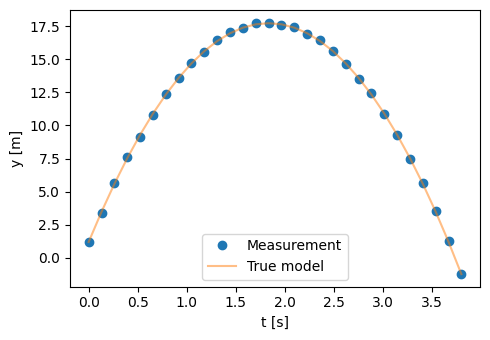

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt

# ----- 1) Model and synthetic data -----
rng = np.random.default_rng(42)

# "True" parameters (unknown during fitting)
g_true  = 9.81     # m/s^2
v0_true = 18.0     # m/s
h0_true = 1.2      # m

def height_model(t, g, v0, h0):
    return h0 + v0*t - 0.5*g*t**2

# Measurement times
t = np.linspace(0.0, 3.8, 30)

# Measurement noise
sigma_y = 0.10
y_clean = height_model(t, g_true, v0_true, h0_true)
y = y_clean + rng.normal(0.0, sigma_y, size=t.size)

# Plot measurements vs. true model
plt.figure(figsize=(5,3.5))
plt.plot(t, y, "o", label="Measurement")
plt.plot(t, y_clean, "-", alpha=0.5, label="True model")
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.legend(); plt.tight_layout()
plt.show()


#### התאמת עקומה והערכת אי־ודאות (`optimize.curve_fit`)  
נתאים את $g, v_0, h_0$ ע"י מיזעור ריבועי השאריות. נזין את $\sigma_y$ ונסמן `absolute_sigma=True` כדי שמטריצת ה־covariance תחושב ביחידות פיזיות נכונות. שגיאות $1\sigma$ הן השורש הריבועי של האיברים על האלכסון.


curve_fit results:
g   = 9.811 ± 0.032 m/s^2
v0  = 18.015 ± 0.063 m/s
h0  = 1.176 ± 0.051 m


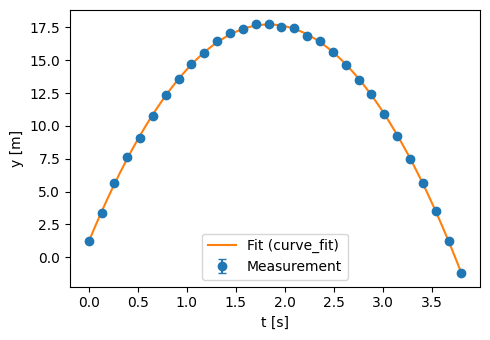

In [4]:
# ----- 2) curve_fit: non-linear fit -----
p0 = (8.0, 10.0, 0.0)  # Initial guess: (g, v0, h0)

popt, pcov = opt.curve_fit(
    f=height_model, xdata=t, ydata=y, p0=p0,
    sigma=np.full_like(t, sigma_y), absolute_sigma=True
)
g_fit, v0_fit, h0_fit = popt
perr = np.sqrt(np.diag(pcov))  # 1σ uncertainty per parameter

print("curve_fit results:")
print(f"g   = {g_fit:.3f} ± {perr[0]:.3f} m/s^2")
print(f"v0  = {v0_fit:.3f} ± {perr[1]:.3f} m/s")
print(f"h0  = {h0_fit:.3f} ± {perr[2]:.3f} m")

# Plot fitted curve
t_dense = np.linspace(t.min(), t.max(), 300)
y_fit = height_model(t_dense, *popt)

plt.figure(figsize=(5,3.5))
plt.errorbar(t, y, yerr=sigma_y, fmt="o", label="Measurement", capsize=3)
plt.plot(t_dense, y_fit, label="Fit (curve_fit)")
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.legend(); plt.tight_layout()
plt.show()


#### מציאת שורש: זמן הפגיעה בקרקע (`optimize.root_scalar`)  
נרצה $t_\text{impact}$ כך ש־$y(t)=0$. נשתמש בפרמטרים המותאמים ונפתור $h_0 + v_0 t - \tfrac{1}{2} g t^2 = 0$.  
שיטה בטוחה: **Brent** עם מסגרת `[a,b]` שבה הפונקציה מחליפה סימן. אפשר גם **Newton** אם יש נגזרת טובה וניחוש קרוב.

In [5]:
# ----- 3) root_scalar: find t where y(t)=0 -----
def height_fit_only_t(t):
    return height_model(t, g_fit, v0_fit, h0_fit)

# (a) Brent: requires bracket with sign change
sol_brent = opt.root_scalar(height_fit_only_t, bracket=[0.0, 5.0], method='brentq')
t_impact_brent = sol_brent.root

# (b) Newton: requires derivative and initial guess
def dheight_dt(t):
    return v0_fit - g_fit*t

sol_newton = opt.root_scalar(height_fit_only_t, fprime=dheight_dt, x0=3.0, method='newton')
t_impact_newton = sol_newton.root

print(f"t_impact (Brent)  = {t_impact_brent:.4f} s")
print(f"t_impact (Newton) = {t_impact_newton:.4f} s")


t_impact (Brent)  = 3.7365 s
t_impact (Newton) = 3.7365 s


#### חיפוש מינימום חד־ממדי: זמן הגובה המירבי (`optimize.minimize_scalar`)  
הגובה מקסימלי כש־$\tfrac{d y}{dt}=0$. במקום לפתור שורש לנגזרת, נוכל למזער את $-y(t)$ על תחום פיזיקלי סביר.


In [6]:
# ----- 4) minimize_scalar: find time of max height -----
res_min1d = opt.minimize_scalar(
    lambda tt: -height_fit_only_t(tt),
    bounds=(0.0, 5.0), method='bounded'
)
t_peak = res_min1d.x
y_peak = height_fit_only_t(t_peak)

print(f"t_peak ≈ {t_peak:.4f} s,  y_peak ≈ {y_peak:.3f} m")

# Alternative via derivative root:
sol_dydt0 = opt.root_scalar(lambda tt: v0_fit - g_fit*tt, bracket=[0.0, 5.0], method='brentq')
print(f"t_peak via dy/dt=0: {sol_dydt0.root:.4f} s")


t_peak ≈ 1.8362 s,  y_peak ≈ 17.715 m
t_peak via dy/dt=0: 1.8362 s


#### מינימיזציה רב־ממדית: $\chi$־בריבוע ידני (`optimize.minimize`)  
כאן נבנה פונקציית עלות $\chi^2(g,v_0,h_0)$ ונמזער אותה ישירות. זה מדגים שימוש ב־`minimize` כחלופה כללית ל־`curve_fit`.


In [7]:
# ----- 5) minimize (multi-dimensional) chi^2 -----
def chi2(params):
    g, v0, h0 = params
    y_model = height_model(t, g, v0, h0)
    r = (y - y_model) / sigma_y
    return np.sum(r*r)

x0 = np.array([8.0, 10.0, 0.0])  # Initial guess
bounds = [(0.0, 30.0), (-100.0, 100.0), (-10.0, 10.0)]  # Reasonable bounds

res = opt.minimize(chi2, x0=x0, bounds=bounds, method="L-BFGS-B")
g_m, v0_m, h0_m = res.x

print("minimize results (chi^2):")
print(f"g   = {g_m:.3f}, v0 = {v0_m:.3f}, h0 = {h0_m:.3f}, chi2 = {res.fun:.2f}")


minimize results (chi^2):
g   = 9.811, v0 = 18.015, h0 = 1.176, chi2 = 16.88


#### תרגום אי־ודאות לזמן הפגיעה  
ברשותנו $ \mathrm{Cov}(\mathbf{p}) $ עבור $\mathbf{p}=(g,v_0,h_0)$. אי־הוודאות של $t_\text{impact}$ ניתנת בקירוב ע"י:

$$
\sigma_{t} \approx \frac{\sqrt{\mathbf{J}_p \, \mathrm{Cov}(\mathbf{p}) \, \mathbf{J}_p^\top}}{\left| \frac{\partial y}{\partial t}(t_\text{impact}) \right|}
$$

כאשר $\mathbf{J}_p = \left[\tfrac{\partial y}{\partial g}, \tfrac{\partial y}{\partial v_0}, \tfrac{\partial y}{\partial h_0}\right]$ מוערכת בנקודת $t_\text{impact}$.


In [8]:
# ----- 6) Propagate parameter covariance to impact time -----
t_star = t_impact_brent

Jp = np.array([
    -0.5 * t_star**2,   # d y / d g
     t_star,            # d y / d v0
     1.0                # d y / d h0
]).reshape(1, -1)

num = Jp @ pcov @ Jp.T
den = abs(v0_fit - g_fit*t_star)  # |dy/dt| at impact
sigma_t = float(np.sqrt(num) / den)

print(f"t_impact = {t_star:.4f} ± {sigma_t:.4f} s  (≈1σ)")


t_impact = 3.7365 ± 0.0026 s  (≈1σ)


/tmp/ipykernel_28732/4176238823.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_t = float(np.sqrt(num) / den)


### scipy.optimize.minimize — מינימיזציה כללית של פונקציה סקלרית

לעיתים אנחנו רוצים למצוא ערכים של וקטור משתנים $x$ שממזערים פונקציה סקלרית $f(x)$. הפונקציה scipy.optimize.minimize נותנת ממשק אחיד להרבה אלגוריתמים (עם/בלי נגזרות), וגם תומכת בגבולות (bounds) ו־אילוצים (constraints).

חתימת שימוש נפוצה (לא חייבים את כל הפרמטרים):
```python
from scipy import optimize

res = optimize.minimize(
    fun, x0,
    args=(),
    method=None,
    jac=None,
    bounds=None,
    constraints=(),
    tol=None,
    options=None
)
```


הפלט הוא אובייקט OptimizeResult (דומה למילון) עם שדות חשובים כמו:

res.x — הפתרון שנמצא
res.fun — ערך הפונקציה בפתרון
res.success — האם האלגוריתם הסתיים בהצלחה
res.message — הסבר לסיבת העצירה

#### דוגמה 1: מינימיזציה ללא אילוצים (עם נגזרת)

נמזער $f(x)=(x−2)^2$
. מתמטית ברור שהמינימום ב־$x=2$, אבל זו דוגמה טובה לזרימת עבודה.

In [9]:
import numpy as np
from scipy import optimize

def f(x):
    return (x[0] - 2.0)**2

def grad_f(x):
    return np.array([2.0*(x[0] - 2.0)])

res = optimize.minimize(f, x0=np.array([0.0]), jac=grad_f, method="BFGS")

print("x* =", res.x)
print("f(x*) =", res.fun)
print("success =", res.success)
print("message =", res.message)


x* = [2.]
f(x*) = 0.0
success = True
message = Optimization terminated successfully.


#### דוגמה 2: גבולות (bounds) — משתנים תחומים

כאן נחייב את $x$ להיות בתחום [−1,1].

In [10]:
from scipy import optimize
import numpy as np

def g(x):
    return (x[0] - 2.0)**2 

bounds = [(-1.0, 1.0)]

res = optimize.minimize(g, x0=np.array([0.0]), method="L-BFGS-B", bounds=bounds)
print(res.x, res.fun, res.success)


[1.] 1.0 True


כאן הפתרון יתקרב ל־ $x=1$ (קצה התחום), כי 2 מחוץ ל־bounds.

### סיכום   
- **התאמה (`curve_fit`)** מספקת פרמטרים מיטביים ו־**covariance** להערכת אי־ודאות פיזיקלית.  
- **שורשים (`root_scalar`)** מתאימים לחישוב נקודות זמן/מיקום של אירוע (כמו $y=0$).  
- **מינימום חד־ממדי (`minimize_scalar`)** שימושי למציאת רגעי קיצון או נקודות אופטימליות.  
- **מינימום רב־ממדי (`minimize`)** נותן גמישות מלאה בהגדרת פונקציית עלות ואילוצים.  

טיפי עבודה: הקפידו על סולמות גודל טובים, מסגרות (`bracket`) לשורשים/מינימום, וניחושי פתיחה הגיוניים. עבור התאמות, ספקו `sigma` אמינה ו־`absolute_sigma=True` כדי לקבל שגיאות בפרמטרים ביחידות הנכונות.


In [11]:
import json
from jupyterquiz import display_quiz
from IPython.display import Javascript, display

quiz_json = r'''
[
  {
    "question": "איזו שיטה ב-<code>optimize.root_scalar</code> מתאימה במיוחד כשידוע תחום שבו הפונקציה מחליפה סימן (למשל בין 0 ל-5)?",
    "type": "many_choice",
    "answers": [
      {
        "answer": "<code>method='brentq'</code> עם <code>bracket=(0,5)</code>",
        "correct": true,
        "feedback": "נכון! Brent (בגרסת brentq) דורש מסגרת עם החלפת סימן ומספק התכנסות אמינה."
      },
      {
        "answer": "<code>method='newton'</code> עם <code>x0=2.5</code> ללא נגזרת",
        "correct": false,
        "feedback": "לא מדויק — ניוטון רגיש לניחוש התחלתי ולרוב דורש נגזרת כדי להיות יציב ומהיר."
      },
      {
        "answer": "<code>method='secant'</code> ללא מסגרת וללא נגזרת",
        "correct": false,
        "feedback": "לא נכון — שיטת הסקנט יכולה לעבוד, אך ללא מסגרת היא פחות אמינה מה-Brent כשיש החלפת סימן."
      },
      {
        "answer": "<code>fsolve</code> עם <code>x0=2.5</code>",
        "correct": false,
        "feedback": "לא נכון — <code>fsolve</code> מיועד לבעיות רב-ממד/וקטוריות ומתבסס על ניוטון; כאן עדיף <code>root_scalar</code> עם מסגרת."
      }
    ]
  },
  {
    "question": "ברצונך למזער פונקציה חד-ממדית $f(t)$ בתחום הקשור בגבולות: $0 \\le t \\le 5$. איזו קריאה מתאימה?",
    "type": "many_choice",
    "answers": [
      {
        "answer": "<code>optimize.minimize_scalar(f, bounds=(0,5), method='bounded')</code>",
        "correct": true,
        "feedback": "נכון! השיטה <code>bounded</code> ב-<code>minimize_scalar</code> מתאימה למינימיזציה עם גבולות סופיים."
      },
      {
        "answer": "<code>optimize.minimize_scalar(f, bracket=(0,5))</code>",
        "correct": false,
        "feedback": "לא מדויק — <code>bracket</code> נותן תחום חיפוש אבל לא מכריח גבולות; לחיוב גבולות השתמש ב-<code>method='bounded'</code>."
      },
      {
        "answer": "<code>optimize.minimize(f, x0=2.5)</code>",
        "correct": false,
        "feedback": "לא נכון — <code>minimize</code> הוא לכלים רב-ממדיים; לחד-ממדי עם גבולות עדיף <code>minimize_scalar</code> עם <code>bounded</code>."
      },
      {
        "answer": "<code>optimize.curve_fit(f, t, y)</code>",
        "correct": false,
        "feedback": "לא נכון — <code>curve_fit</code> מיועד להתאמת פרמטרים למודל לנתונים, לא למינימיזציה כללית על ציר יחיד."
      }
    ]
  },
  {
    "question": "בהתאמה של מודל ליניארי $y = a x + b$ עם <code>optimize.curve_fit</code>, כיצד כדאי לפעול כדי שהשגיאות $1\\sigma$ על $a,b$ (מהאלכסון של מטריצת ה-covariance) יהיו ביחידות פיזיקליות נכונות?",
    "type": "many_choice",
    "answers": [
      {
        "answer": "להעביר וקטור <code>sigma</code> עם סטיות התקן של המדידות ולציין <code>absolute_sigma=True</code>",
        "correct": true,
        "feedback": "נכון! אז ה-covariance מחושב בסקאלה פיזיקלית; השגיאות הן $\\sqrt{\\mathrm{diag}(\\mathrm{Cov})}$."
      },
      {
        "answer": "להגדיל את <code>maxfev</code> כדי שההתאמה תתכנס טוב יותר",
        "correct": false,
        "feedback": "לא מספיק — זה עשוי לעזור להתכנסות אך לא קובע את סקלת ה-covariance ביחידות פיזיקליות."
      },
      {
        "answer": "לנרמל את $x,y$ לטווח [0,1] לפני התאמה",
        "correct": false,
        "feedback": "נירמול יכול לעזור נומרית, אך אינו מחליף <code>sigma</code> ו-<code>absolute_sigma=True</code> לצורך פירוש שגיאות."
      },
      {
        "answer": "להשתמש ב-<code>p0</code> קרוב לערכים האמיתיים",
        "correct": false,
        "feedback": "ניחוש התחלתי טוב מסייע, אך אינו מבטיח ש-covariance יתוקנן פיזיקלית ללא <code>sigma</code> ו-<code>absolute_sigma=True</code>."
      }
    ]
  }
]
'''

myquiz = json.loads(quiz_json)
display_quiz(myquiz)

display(Javascript("""
(() => {
  if (window.MathJax) {
    if (MathJax.typesetPromise) { MathJax.typesetPromise(); }
    else if (MathJax.Hub && MathJax.Hub.Queue) { MathJax.Hub.Queue(['Typeset', MathJax.Hub]); }
  }
})();
"""))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>